# This notebook uses pytorch lightning & optuna & a Recurrent Attentive Neural Process for Sequential Data (RANPfSQ)

This notebook trains an Attentional Neural Network on timeseries data from smartmeters.

It uses pytorch lighting for the training loop. And Optuna for the hyperparameter optimisation.

It also pushes results to the tensorboard hyperparameter dashboard for examination.

- https://github.com/optuna/optuna/blob/master/examples/pytorch_lightning_simple.py

- similar to https://arxiv.org/abs/1910.09323

Results on *Smartmeter* prediction

|Model|val_loss|
|--|--| 
|ANP-RNN|-1.27|
|ANP-RNN_imp|-1.38|
|ANP|-1.3|
|ANP_impr|-1.2|
|NP|-1.3|

In [1]:
import sys, re, os, itertools, functools, collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import optuna
import pytorch_lightning as pl
from optuna.integration import PyTorchLightningPruningCallback


import math
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("RANP.ipynb")

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
from src.models.model import LatentModel
from src.data.smart_meter import collate_fns, SmartMeterDataSet, get_smartmeter_df
from src.plot import plot_from_loader
from src.models.lightning_anp import LatentModelPL
from src.dict_logger import DictLogger
from src.utils import PyTorchLightningPruningCallback
from src.train import main, objective, add_number, run_trial

In [5]:
# Params
device='cuda'
use_logy=False

# Load kaggle smart meter data

In [6]:
df_train, df_val, df_test = get_smartmeter_df()

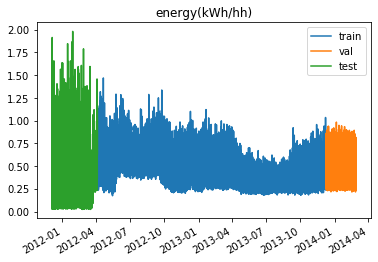

In [7]:
# Show split
df_train['energy(kWh/hh)'].plot(label='train')
df_val['energy(kWh/hh)'].plot(label='val')
df_test['energy(kWh/hh)'].plot(label='test')
plt.title('energy(kWh/hh)')
plt.legend()

# Train helpers

# Default params

In [8]:
default_params = {
 'attention_dropout': 0.1,
 'attention_layers': 2,
 'batchnorm': False,
 'det_enc_cross_attn_type': 'multihead',
 'det_enc_self_attn_type': 'uniform',
 'dropout': 0.2,
 'hidden_dim': 256,
 'latent_dim': 256,
 'latent_enc_self_attn_type': 'uniform',
 'learning_rate': 3e-4,
 'n_decoder_layers': 4,
 'n_det_encoder_layers': 4,
 'n_latent_encoder_layers': 2,
 'num_heads': 8,
 'use_deterministic_path': True,
 'use_lvar': True,
 'use_self_attn': True,
 'use_rnn': False,
}
default_attrs = {
    'context_in_target': True,
    'x_dim': 17,
     'y_dim': 1,
    'vis_i': '670',
    'num_workers': 3,
    'num_context': 24*4,
    'num_extra_target': 24*4,
    'max_nb_epochs': 200,
    'min_std': 0.005,
    'grad_clip': 40,
    'batch_size': 16,
    'patience': 2
}

# Train ANP-RNN

now run `tensorboard --logdir lightning_logs`
trial.number -5
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
    | Name                                                                      | Type                 | Params
---------------------------------------------------------------------------------------------------------------
0   | model                                                                     | LatentModel          | 7 M   
1   | model.norm_x                                                              | BatchNormSequence    | 34    
2   | model.norm_x.norm                                                         | BatchNorm1d          | 34    
3   | model.norm_y                                                              | BatchNormSequence    | 2     
4   | model.norm_y.norm                                                         | BatchNorm1d          | 2     
5   | model._lstm_x                                                        

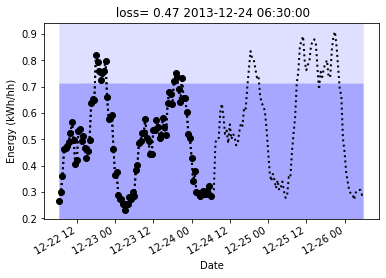

step val 0, {'val_loss': '0.42184552550315857', 'val/kl': '2.1713795206323994e-07', 'val/std': '0.6983310580253601', 'val/mse': '0.26364341378211975'} {}


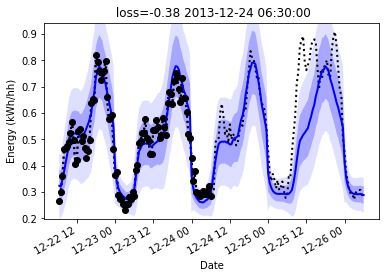

step val 1826, {'val_loss': '-0.6428284049034119', 'val/kl': '5.4591797379544005e-05', 'val/std': '0.07988817989826202', 'val/mse': '0.0059888968244194984'} {'train_loss': -0.4425143003463745, 'train/kl': 5.353632150217891e-05, 'train/std': 0.11668403446674347, 'train/mse': 0.014617819339036942}


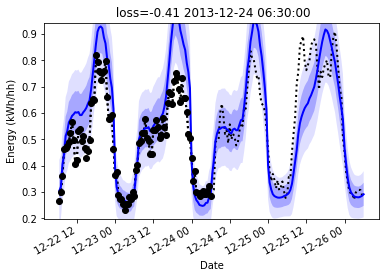

step val 3653, {'val_loss': '-0.6794694662094116', 'val/kl': '0.00012594334839377552', 'val/std': '0.06845888495445251', 'val/mse': '0.0053461468778550625'} {'train_loss': -0.6174005270004272, 'train/kl': 6.462969031417742e-05, 'train/std': 0.08038288354873657, 'train/mse': 0.008405664935708046}


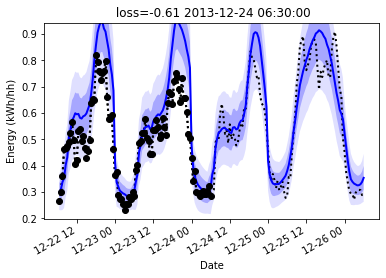

step val 5480, {'val_loss': '-0.6641156673431396', 'val/kl': '0.00010334183753002435', 'val/std': '0.06985745579004288', 'val/mse': '0.005731998011469841'} {'train_loss': -0.6783930659294128, 'train/kl': 6.751970067853108e-05, 'train/std': 0.07189679890871048, 'train/mse': 0.007116572465747595}


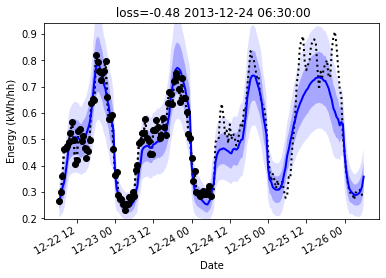

step val 7307, {'val_loss': '-0.64785236120224', 'val/kl': '6.461514567490667e-05', 'val/std': '0.06351888924837112', 'val/mse': '0.005672703497111797'} {'train_loss': -0.702958881855011, 'train/kl': 6.77721545798704e-05, 'train/std': 0.06865207850933075, 'train/mse': 0.006534663029015064}


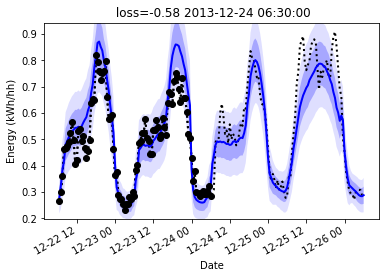

step val 9134, {'val_loss': '-0.7176527976989746', 'val/kl': '4.687508044298738e-05', 'val/std': '0.05477931722998619', 'val/mse': '0.004916038364171982'} {'train_loss': -0.7147323489189148, 'train/kl': 6.48987406748347e-05, 'train/std': 0.06696134805679321, 'train/mse': 0.006167554296553135}


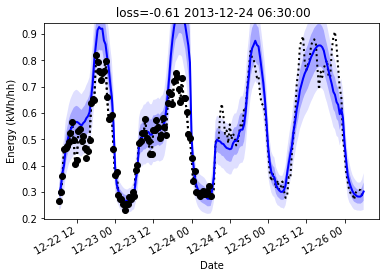

step val 10961, {'val_loss': '-0.7569440007209778', 'val/kl': '5.361469811759889e-05', 'val/std': '0.049641843885183334', 'val/mse': '0.004109958652406931'} {'train_loss': -0.7449450492858887, 'train/kl': 6.57353739370592e-05, 'train/std': 0.06346124410629272, 'train/mse': 0.005816280841827393}


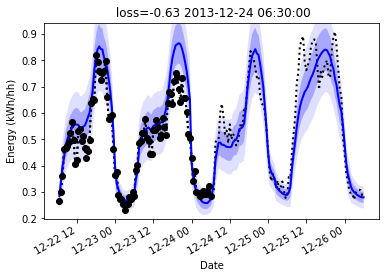

step val 12788, {'val_loss': '-0.7574060559272766', 'val/kl': '3.885324258590117e-05', 'val/std': '0.04863661155104637', 'val/mse': '0.003958649933338165'} {'train_loss': -0.774450421333313, 'train/kl': 6.246966950129718e-05, 'train/std': 0.06125149503350258, 'train/mse': 0.005521796178072691}


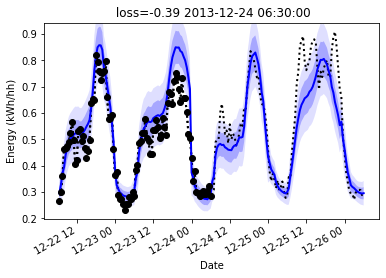

step val 14615, {'val_loss': '-0.655064046382904', 'val/kl': '4.925979737890884e-05', 'val/std': '0.0435226671397686', 'val/mse': '0.004355155397206545'} {'train_loss': -0.7880685925483704, 'train/kl': 6.0735172155546024e-05, 'train/std': 0.05881268531084061, 'train/mse': 0.005228012800216675}


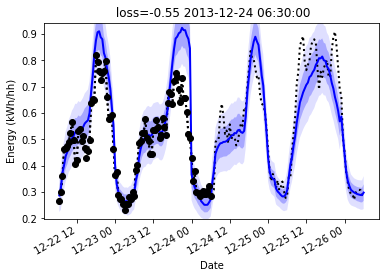

step val 16442, {'val_loss': '-0.7114515900611877', 'val/kl': '3.781724808504805e-05', 'val/std': '0.04664501175284386', 'val/mse': '0.0044994959607720375'} {'train_loss': -0.8029305934906006, 'train/kl': 5.973194492980838e-05, 'train/std': 0.0579378642141819, 'train/mse': 0.005083664786070585}


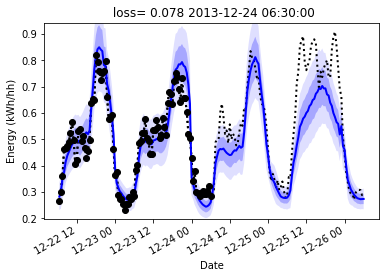

step val 18269, {'val_loss': '-0.5954879522323608', 'val/kl': '3.543590355548076e-05', 'val/std': '0.04523073881864548', 'val/mse': '0.005495685152709484'} {'train_loss': -0.814018964767456, 'train/kl': 5.570444045588374e-05, 'train/std': 0.05588681623339653, 'train/mse': 0.004857610445469618}
Epoch     9: reducing learning rate of group 0 to 3.0000e-05.


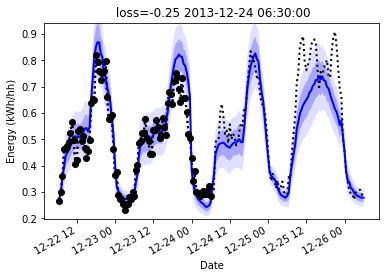

step val 20096, {'val_loss': '-0.636482834815979', 'val/kl': '4.198354508844204e-05', 'val/std': '0.04087801277637482', 'val/mse': '0.004332580137997866'} {'train_loss': -0.8859013319015503, 'train/kl': 5.240697646513581e-05, 'train/std': 0.049901679158210754, 'train/mse': 0.004169043153524399}
INFO:root:Epoch 00011: early stopping

Loading checkpoint lightning_logs/anp-rnn/version_-5/_ckpt_epoch_6.ckpt


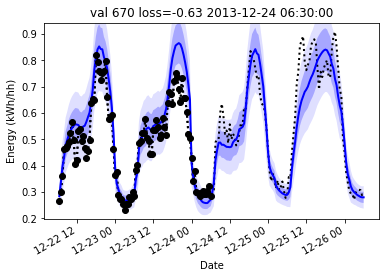

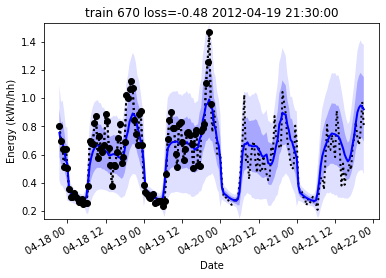

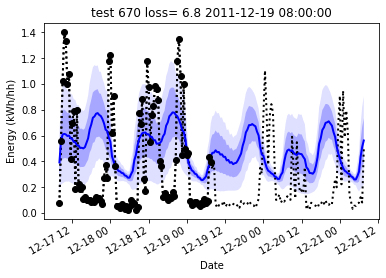

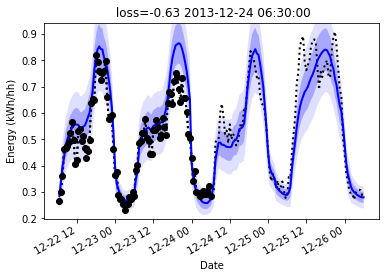

step val 20097, {'val_loss': '5.675908088684082', 'val/kl': '5.951051934971474e-05', 'val/std': '0.11505361646413803', 'val/mse': '0.13731111586093903'} {}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



In [9]:
trial, trainer, model = run_trial(
    name="anp-rnn",
    params={
     **default_params, 
     'det_enc_cross_attn_type': 'multihead',
     'det_enc_self_attn_type': 'uniform',
     'latent_enc_self_attn_type': 'uniform',
     'use_deterministic_path': True,
     'use_rnn': True,
     'use_lvar': False,
    },
    user_attrs = default_attrs,
    PL_MODEL_CLS=LatentModelPL
)

# ANP-RNN 2

now run `tensorboard --logdir lightning_logs`
trial.number -4
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
    | Name                                                                      | Type                 | Params
---------------------------------------------------------------------------------------------------------------
0   | model                                                                     | LatentModel          | 9 M   
1   | model.norm_x                                                              | BatchNormSequence    | 34    
2   | model.norm_x.norm                                                         | BatchNorm1d          | 34    
3   | model.norm_y                                                              | BatchNormSequence    | 2     
4   | model.norm_y.norm                                                         | BatchNorm1d          | 2     
5   | model._lstm_x                                                        

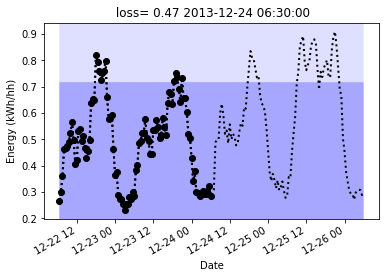

step val 0, {'val_loss': '0.4272317886352539', 'val/kl': '2.016334832433131e-07', 'val/std': '0.708134114742279', 'val/mse': '0.26763391494750977'} {}


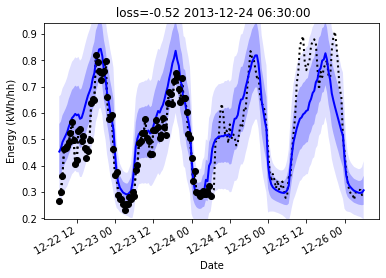

step val 1826, {'val_loss': '-0.6243447065353394', 'val/kl': '0.0001655164232943207', 'val/std': '0.09201371669769287', 'val/mse': '0.006292355712503195'} {'train_loss': -0.4238220751285553, 'train/kl': 0.00010450785339344293, 'train/std': 0.12079621851444244, 'train/mse': 0.014694823883473873}


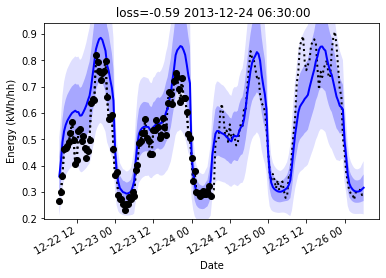

step val 3653, {'val_loss': '-0.7118011713027954', 'val/kl': '0.00016593901091255248', 'val/std': '0.0826723650097847', 'val/mse': '0.004447834100574255'} {'train_loss': -0.6183847784996033, 'train/kl': 0.00015263594104908407, 'train/std': 0.08014649152755737, 'train/mse': 0.008464133366942406}


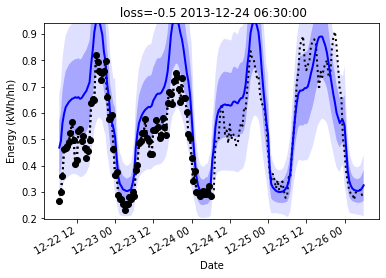

step val 5480, {'val_loss': '-0.658303439617157', 'val/kl': '0.00032418235787190497', 'val/std': '0.08431340754032135', 'val/mse': '0.005865172948688269'} {'train_loss': -0.6666434407234192, 'train/kl': 0.0001958497887244448, 'train/std': 0.07278729975223541, 'train/mse': 0.007329223677515984}


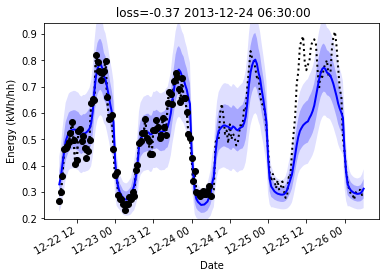

step val 7307, {'val_loss': '-0.7170640230178833', 'val/kl': '0.0001662165013840422', 'val/std': '0.05576356500387192', 'val/mse': '0.005448098294436932'} {'train_loss': -0.6996455788612366, 'train/kl': 0.00019197423534933478, 'train/std': 0.06931658089160919, 'train/mse': 0.0066827693954110146}


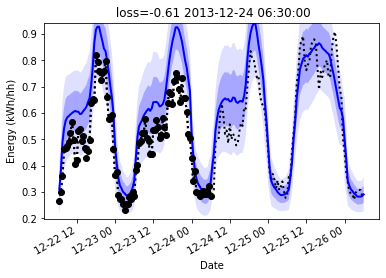

step val 9134, {'val_loss': '-0.7675071954727173', 'val/kl': '0.00015290360897779465', 'val/std': '0.05838920548558235', 'val/mse': '0.0046668751165270805'} {'train_loss': -0.716970682144165, 'train/kl': 0.00018089132208842784, 'train/std': 0.06721778213977814, 'train/mse': 0.006413701921701431}


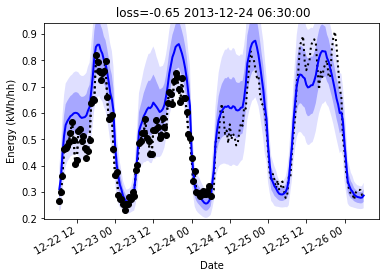

step val 10961, {'val_loss': '-0.7645254731178284', 'val/kl': '0.0001615239161765203', 'val/std': '0.055786460638046265', 'val/mse': '0.0038805422373116016'} {'train_loss': -0.7421634793281555, 'train/kl': 0.00018077155982609838, 'train/std': 0.06484661996364594, 'train/mse': 0.006069732364267111}


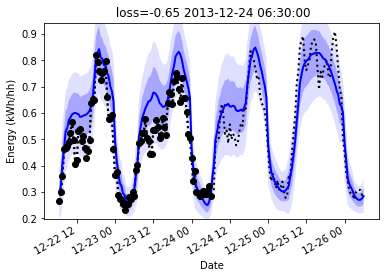

step val 12788, {'val_loss': '-0.7474324107170105', 'val/kl': '0.00015343778068199754', 'val/std': '0.05599140375852585', 'val/mse': '0.004850178025662899'} {'train_loss': -0.765358567237854, 'train/kl': 0.00017713270790409297, 'train/std': 0.06183164194226265, 'train/mse': 0.00569744361564517}


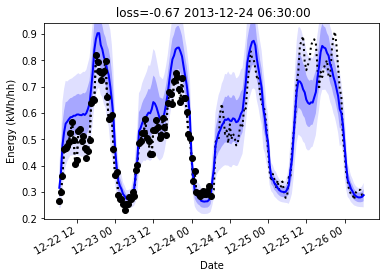

step val 14615, {'val_loss': '-0.7448654174804688', 'val/kl': '8.592780795879662e-05', 'val/std': '0.04981078580021858', 'val/mse': '0.004216459579765797'} {'train_loss': -0.7900658845901489, 'train/kl': 0.00017211325757671148, 'train/std': 0.06001533195376396, 'train/mse': 0.005463994108140469}
Epoch     7: reducing learning rate of group 0 to 3.0000e-05.


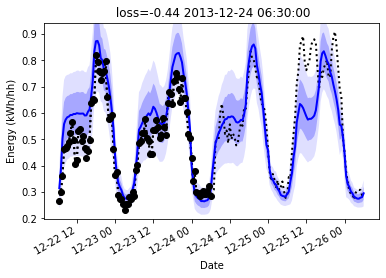

step val 16442, {'val_loss': '-0.6781318783760071', 'val/kl': '9.873737872112542e-05', 'val/std': '0.04399699345231056', 'val/mse': '0.004785820841789246'} {'train_loss': -0.8445413112640381, 'train/kl': 0.00017202386516146362, 'train/std': 0.05372248962521553, 'train/mse': 0.00473695108667016}
INFO:root:Epoch 00009: early stopping

Loading checkpoint lightning_logs/anp-rnn2/version_-4/_ckpt_epoch_4.ckpt


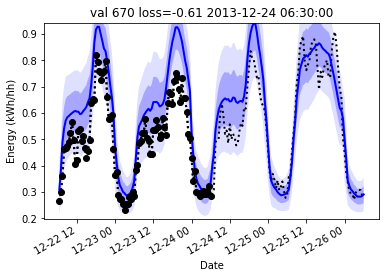

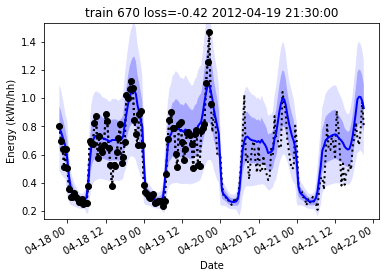

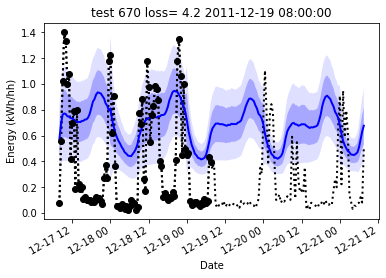

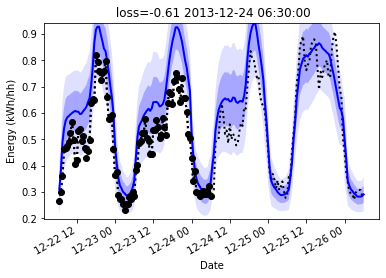

step val 16443, {'val_loss': '2.689519166946411', 'val/kl': '0.0020408218260854483', 'val/std': '0.14355066418647766', 'val/mse': '0.27067017555236816'} {}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



In [10]:
trial, trainer, model = run_trial(
    name="anp-rnn2",
    params={
        **default_params, 
        'det_enc_self_attn_type': 'multihead',
        'latent_enc_self_attn_type': 'multihead',
        'use_deterministic_path': False,
        'use_rnn': True,
        'use_lvar': False,
    },
    user_attrs=default_attrs,
    PL_MODEL_CLS=LatentModelPL)

In [11]:
# trial, trainer, model = run_trial(
#     name="anp-rnn3b",
#     params={
#         **default_params, 
#         'det_enc_self_attn_type': 'ptmultihead',
#         'latent_enc_self_attn_type': 'ptmultihead',
#         'use_deterministic_path': False,
#         'use_rnn': True,
#         'use_lvar': False,
#     },
#     user_attrs=default_attrs,
#     PL_MODEL_CLS=LatentModelPL)

now run `tensorboard --logdir lightning_logs`
trial.number -4
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
    | Name                                                                      | Type                 | Params
---------------------------------------------------------------------------------------------------------------
0   | model                                                                     | LatentModel          | 6 M   
1   | model.norm_x                                                              | BatchNormSequence    | 34    
2   | model.norm_x.norm                                                         | BatchNorm1d          | 34    
3   | model.norm_y                                                              | BatchNormSequence    | 2     
4   | model.norm_y.norm                                                         | BatchNorm1d          | 2     
5   | model._lstm_x                                                        

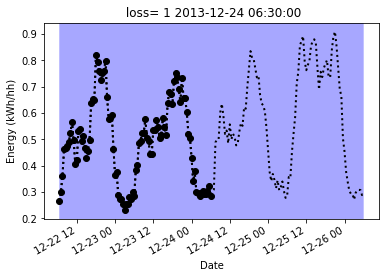

step val 0, {'val_loss': '1.026720404624939', 'val/kl': '0.5007113814353943', 'val/std': '0.9732889533042908', 'val/mse': '0.27839022874832153'} {}


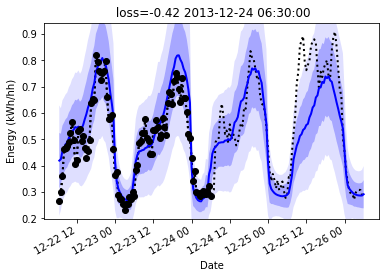

step val 1826, {'val_loss': '-0.5595438480377197', 'val/kl': '0.0010225089499726892', 'val/std': '0.10681277513504028', 'val/mse': '0.006353958044201136'} {'train_loss': -0.3397707939147949, 'train/kl': 0.018496964126825333, 'train/std': 0.14299923181533813, 'train/mse': 0.018082212656736374}


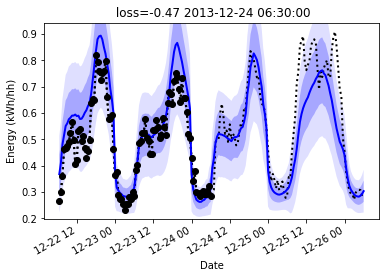

step val 3653, {'val_loss': '-0.6956742405891418', 'val/kl': '0.0003743761917576194', 'val/std': '0.07734071463346481', 'val/mse': '0.004305768292397261'} {'train_loss': -0.584082305431366, 'train/kl': 0.0011084909783676267, 'train/std': 0.08415291458368301, 'train/mse': 0.009035862050950527}


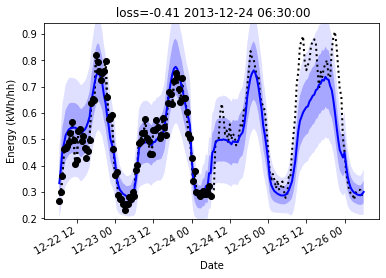

step val 5480, {'val_loss': '-0.660943865776062', 'val/kl': '0.00038441800279542804', 'val/std': '0.06794506311416626', 'val/mse': '0.0067007397301495075'} {'train_loss': -0.6457037329673767, 'train/kl': 0.000914797477889806, 'train/std': 0.07557971775531769, 'train/mse': 0.007583978585898876}


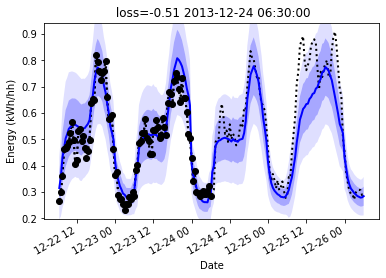

step val 7307, {'val_loss': '-0.6902258396148682', 'val/kl': '0.000548120413441211', 'val/std': '0.06256082653999329', 'val/mse': '0.00506548723205924'} {'train_loss': -0.6821491718292236, 'train/kl': 0.0006638779304921627, 'train/std': 0.07080988585948944, 'train/mse': 0.006849905010312796}


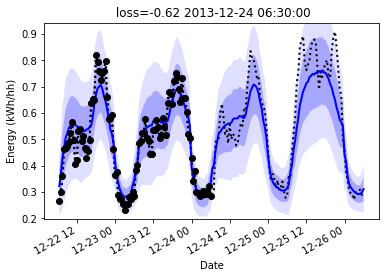

step val 9134, {'val_loss': '-0.6788279414176941', 'val/kl': '0.0004198125097900629', 'val/std': '0.07540367543697357', 'val/mse': '0.006317061837762594'} {'train_loss': -0.6997294425964355, 'train/kl': 0.0005116851534694433, 'train/std': 0.06830525398254395, 'train/mse': 0.006480811629444361}
Epoch     4: reducing learning rate of group 0 to 3.0000e-05.


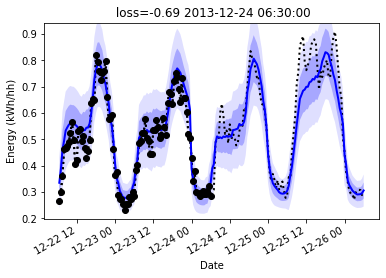

step val 10961, {'val_loss': '-0.7686061263084412', 'val/kl': '0.00026501118554733694', 'val/std': '0.053781475871801376', 'val/mse': '0.003572280751541257'} {'train_loss': -0.7661863565444946, 'train/kl': 0.00034162303199991584, 'train/std': 0.06142435222864151, 'train/mse': 0.005500624421983957}


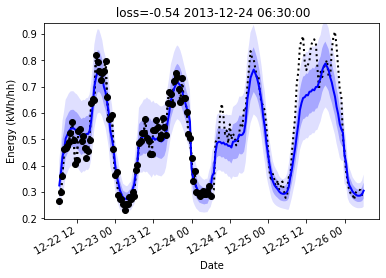

step val 12788, {'val_loss': '-0.6987411379814148', 'val/kl': '0.0002520672569517046', 'val/std': '0.05158507451415062', 'val/mse': '0.0047387173399329185'} {'train_loss': -0.7794477939605713, 'train/kl': 0.00027729771682061255, 'train/std': 0.05976495146751404, 'train/mse': 0.005322746932506561}


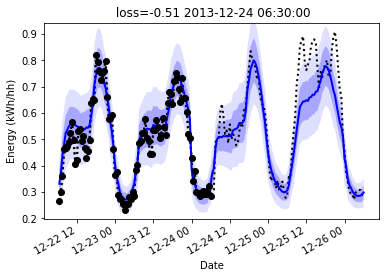

step val 14615, {'val_loss': '-0.7118856906890869', 'val/kl': '0.00027958446298725903', 'val/std': '0.04966074973344803', 'val/mse': '0.004328195936977863'} {'train_loss': -0.7852046489715576, 'train/kl': 0.00026115216314792633, 'train/std': 0.059137631207704544, 'train/mse': 0.005295000970363617}


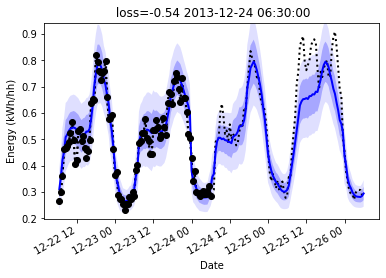

step val 16442, {'val_loss': '-0.693724513053894', 'val/kl': '0.00022185625857673585', 'val/std': '0.04828304052352905', 'val/mse': '0.004384470172226429'} {'train_loss': -0.7984015941619873, 'train/kl': 0.00024578155716881156, 'train/std': 0.05835358053445816, 'train/mse': 0.005178666207939386}
Epoch     8: reducing learning rate of group 0 to 3.0000e-06.


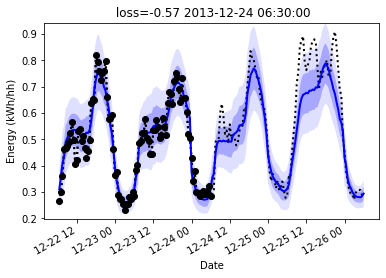

step val 18269, {'val_loss': '-0.679880678653717', 'val/kl': '0.00024899686104618013', 'val/std': '0.04855526238679886', 'val/mse': '0.004621494561433792'} {'train_loss': -0.8050701022148132, 'train/kl': 0.00024039045092649758, 'train/std': 0.05741057172417641, 'train/mse': 0.0051253121346235275}
INFO:root:Epoch 00010: early stopping

Loading checkpoint lightning_logs/anp-rnn3/version_-4/_ckpt_epoch_5.ckpt


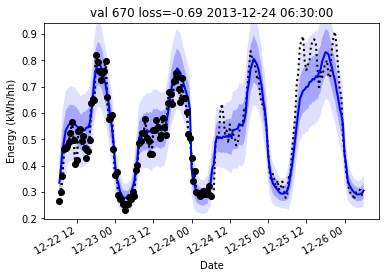

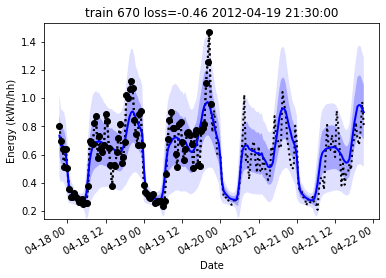

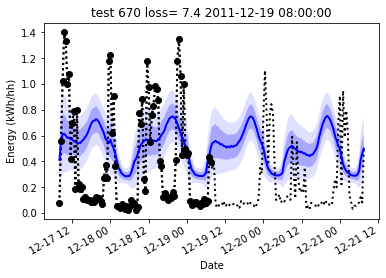

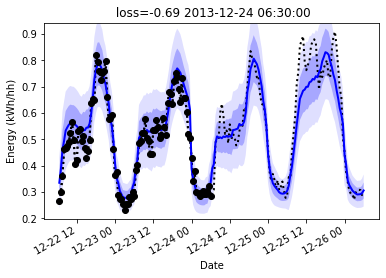

step val 18270, {'val_loss': '5.094888687133789', 'val/kl': '0.0008846893324516714', 'val/std': '0.09817715734243393', 'val/mse': '0.1575705111026764'} {}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



In [20]:
trial, trainer, model = run_trial(
    name="anp-rnn3",
    params={
        **default_params,
        'det_enc_self_attn_type': 'ptmultihead',
        'latent_enc_self_attn_type': 'ptmultihead',
        'use_deterministic_path': False,
        'use_rnn': True
    },
    user_attrs=default_attrs,
    PL_MODEL_CLS=LatentModelPL)

# ANP

now run `tensorboard --logdir lightning_logs`
trial.number -2
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
    | Name                                                                      | Type                 | Params
---------------------------------------------------------------------------------------------------------------
0   | model                                                                     | LatentModel          | 7 M   
1   | model.norm_x                                                              | BatchNormSequence    | 34    
2   | model.norm_x.norm                                                         | BatchNorm1d          | 34    
3   | model.norm_y                                                              | BatchNormSequence    | 2     
4   | model.norm_y.norm                                                         | BatchNorm1d          | 2     
5   | model._latent_encoder                                                

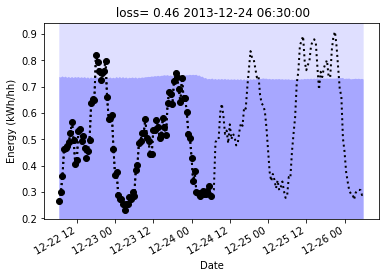

step val 0, {'val_loss': '0.4124463200569153', 'val/kl': '0.000867909868247807', 'val/std': '0.6997844576835632', 'val/mse': '0.24223445355892181'} {}


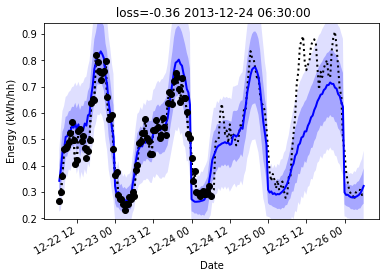

step val 1826, {'val_loss': '-0.6180389523506165', 'val/kl': '0.0019512423314154148', 'val/std': '0.08328787237405777', 'val/mse': '0.005984470713883638'} {'train_loss': -0.4015297591686249, 'train/kl': 0.002748532220721245, 'train/std': 0.12619516253471375, 'train/mse': 0.015218577347695827}


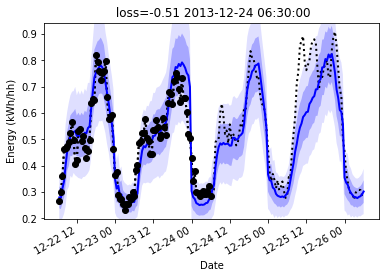

step val 3653, {'val_loss': '-0.7278807163238525', 'val/kl': '0.0014059479581192136', 'val/std': '0.0711861178278923', 'val/mse': '0.004501875024288893'} {'train_loss': -0.6152340173721313, 'train/kl': 0.0023364636581391096, 'train/std': 0.07921499758958817, 'train/mse': 0.00786618236452341}


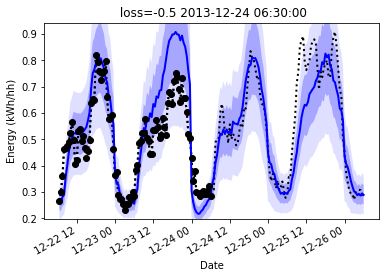

step val 5480, {'val_loss': '-0.6745252013206482', 'val/kl': '0.0015218108892440796', 'val/std': '0.07711585611104965', 'val/mse': '0.0046296496875584126'} {'train_loss': -0.6714304685592651, 'train/kl': 0.0019991567824035883, 'train/std': 0.07271461933851242, 'train/mse': 0.006999595556408167}


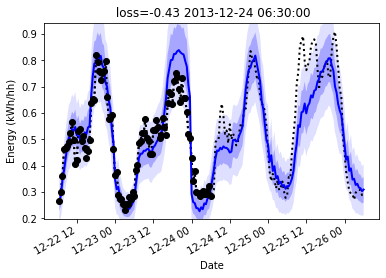

step val 7307, {'val_loss': '-0.724380612373352', 'val/kl': '0.0008795351022854447', 'val/std': '0.06039521470665932', 'val/mse': '0.004034927114844322'} {'train_loss': -0.7004716396331787, 'train/kl': 0.0017743543721735477, 'train/std': 0.06857810914516449, 'train/mse': 0.006414421368390322}


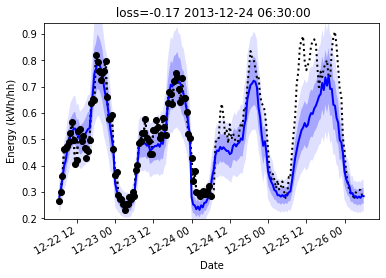

step val 9134, {'val_loss': '-0.6695749163627625', 'val/kl': '0.000799733679741621', 'val/std': '0.0568060502409935', 'val/mse': '0.005037679336965084'} {'train_loss': -0.7123773097991943, 'train/kl': 0.0018125061178579926, 'train/std': 0.06797994673252106, 'train/mse': 0.006316928658634424}
Epoch     4: reducing learning rate of group 0 to 3.0000e-05.


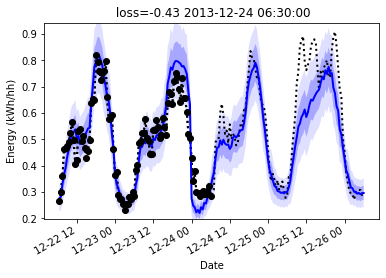

step val 10961, {'val_loss': '-0.6955886483192444', 'val/kl': '0.0007163399131968617', 'val/std': '0.04849543794989586', 'val/mse': '0.004054063931107521'} {'train_loss': -0.7836372256278992, 'train/kl': 0.001564738224260509, 'train/std': 0.059349723160266876, 'train/mse': 0.005054727662354708}
INFO:root:Epoch 00006: early stopping

Loading checkpoint lightning_logs/anp_c/version_-2/_ckpt_epoch_1.ckpt


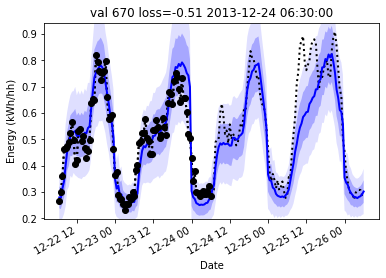

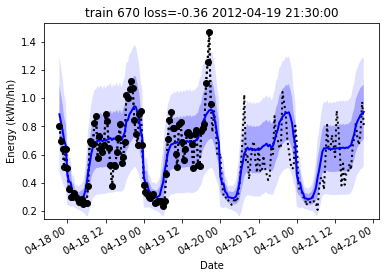

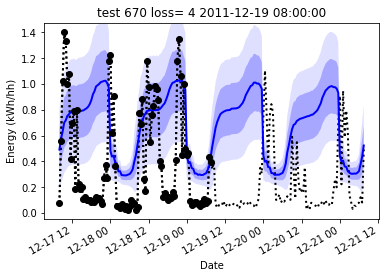

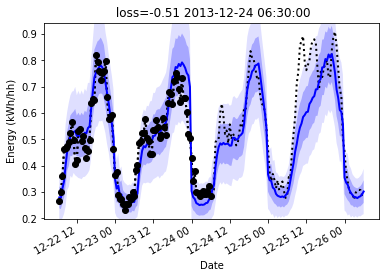

step val 10962, {'val_loss': '2.7513883113861084', 'val/kl': '0.022496435791254044', 'val/std': '0.17759346961975098', 'val/mse': '0.28182995319366455'} {}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



In [14]:
trial, trainer, model = run_trial(name="anp_c",
                                  params={
                                      **default_params,
                                      'det_enc_cross_attn_type': 'multihead',
                                      'det_enc_self_attn_type': 'multihead',
                                      'latent_enc_self_attn_type': 'multihead',
                                      'use_deterministic_path': False,
                                      'use_lvar': False,
                                  },
                                  user_attrs=default_attrs,
                                  PL_MODEL_CLS=LatentModelPL)

now run `tensorboard --logdir lightning_logs`
trial.number -2
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
    | Name                                                                      | Type                 | Params
---------------------------------------------------------------------------------------------------------------
0   | model                                                                     | LatentModel          | 9 M   
1   | model.norm_x                                                              | BatchNormSequence    | 34    
2   | model.norm_x.norm                                                         | BatchNorm1d          | 34    
3   | model.norm_y                                                              | BatchNormSequence    | 2     
4   | model.norm_y.norm                                                         | BatchNorm1d          | 2     
5   | model._latent_encoder                                                

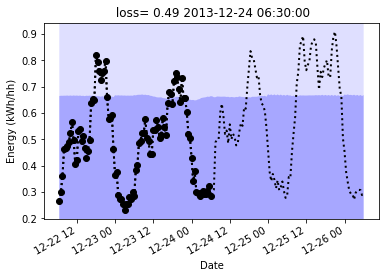

step val 0, {'val_loss': '0.43982192873954773', 'val/kl': '0.0006571835256181657', 'val/std': '0.6844580769538879', 'val/mse': '0.29960399866104126'} {}


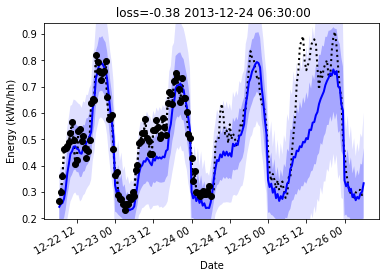

step val 1826, {'val_loss': '-0.5597448348999023', 'val/kl': '0.0010788586223497987', 'val/std': '0.09572924673557281', 'val/mse': '0.008218586444854736'} {'train_loss': -0.35748064517974854, 'train/kl': 0.0022839053999632597, 'train/std': 0.13907167315483093, 'train/mse': 0.017793959006667137}


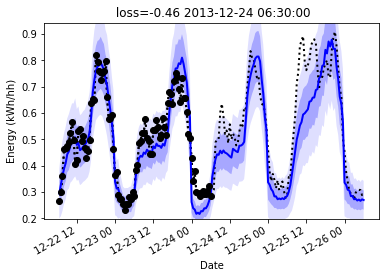

step val 3653, {'val_loss': '-0.6659052968025208', 'val/kl': '0.001045938115566969', 'val/std': '0.06598107516765594', 'val/mse': '0.00438737403601408'} {'train_loss': -0.6084573864936829, 'train/kl': 0.0018979157321155071, 'train/std': 0.08042319118976593, 'train/mse': 0.008051631040871143}


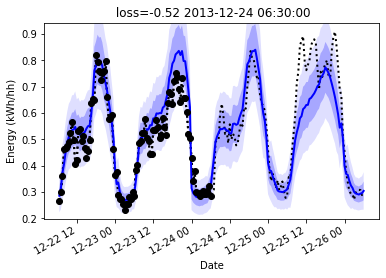

step val 5480, {'val_loss': '-0.7188330888748169', 'val/kl': '0.0010508011328056455', 'val/std': '0.060397207736968994', 'val/mse': '0.004563245456665754'} {'train_loss': -0.6739754676818848, 'train/kl': 0.0018278189236298203, 'train/std': 0.07296169549226761, 'train/mse': 0.0070334551855921745}


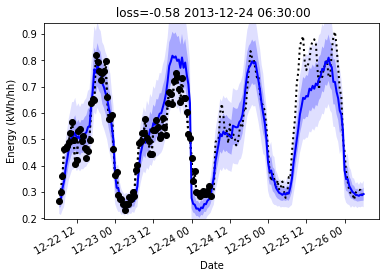

step val 7307, {'val_loss': '-0.6969916820526123', 'val/kl': '0.0010379372397437692', 'val/std': '0.05430024862289429', 'val/mse': '0.005199989769607782'} {'train_loss': -0.7058612108230591, 'train/kl': 0.001559548545628786, 'train/std': 0.06874026358127594, 'train/mse': 0.006453181616961956}


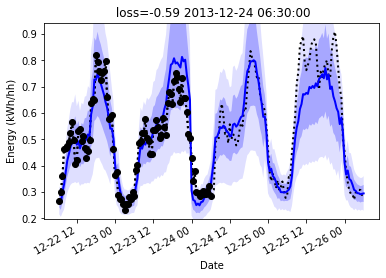

step val 9134, {'val_loss': '-0.6858823895454407', 'val/kl': '0.0008773907902650535', 'val/std': '0.07987513393163681', 'val/mse': '0.005739749874919653'} {'train_loss': -0.7223997712135315, 'train/kl': 0.0015210185665637255, 'train/std': 0.06705736368894577, 'train/mse': 0.006151153240352869}


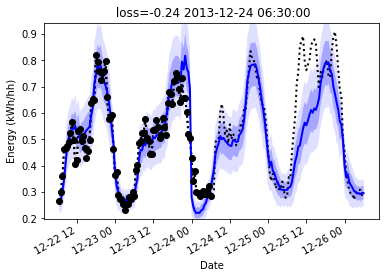

step val 10961, {'val_loss': '-0.7021335959434509', 'val/kl': '0.0008041483233682811', 'val/std': '0.05238235741853714', 'val/mse': '0.004420850425958633'} {'train_loss': -0.7431835532188416, 'train/kl': 0.001334377215243876, 'train/std': 0.06409317255020142, 'train/mse': 0.005752872209995985}
Epoch     5: reducing learning rate of group 0 to 3.0000e-05.


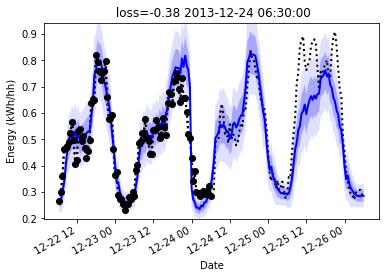

step val 12788, {'val_loss': '-0.7109814882278442', 'val/kl': '0.0006971193361096084', 'val/std': '0.046636518090963364', 'val/mse': '0.004250768572092056'} {'train_loss': -0.8182313442230225, 'train/kl': 0.001185458735562861, 'train/std': 0.05582946166396141, 'train/mse': 0.004642571788281202}
INFO:root:Epoch 00007: early stopping

Loading checkpoint lightning_logs/anp_b/version_-2/_ckpt_epoch_2.ckpt


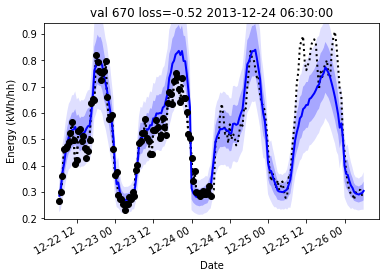

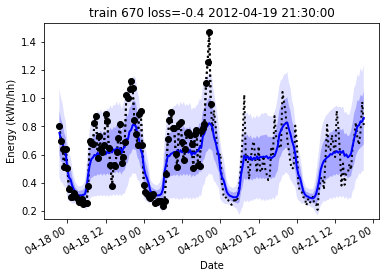

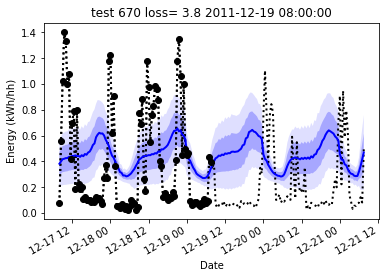

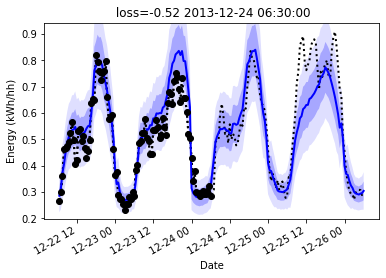

step val 12789, {'val_loss': '3.416766881942749', 'val/kl': '0.007747343275696039', 'val/std': '0.14099794626235962', 'val/mse': '0.13895587623119354'} {}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



In [13]:
trial, trainer, model = run_trial(name="anp_b",
                                  params={
                                      **default_params,
                                      'det_enc_cross_attn_type': 'multihead',
                                      'det_enc_self_attn_type': 'multihead',
                                      'latent_enc_self_attn_type': 'multihead',
                                      'use_deterministic_path': True,
                                      'use_lvar': False,
                                  },
                                  user_attrs=default_attrs,
                                  PL_MODEL_CLS=LatentModelPL)

now run `tensorboard --logdir lightning_logs`
trial.number -3
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
    | Name                                                                      | Type                 | Params
---------------------------------------------------------------------------------------------------------------
0   | model                                                                     | LatentModel          | 3 M   
1   | model.norm_x                                                              | BatchNormSequence    | 34    
2   | model.norm_x.norm                                                         | BatchNorm1d          | 34    
3   | model.norm_y                                                              | BatchNormSequence    | 2     
4   | model.norm_y.norm                                                         | BatchNorm1d          | 2     
5   | model._latent_encoder                                                

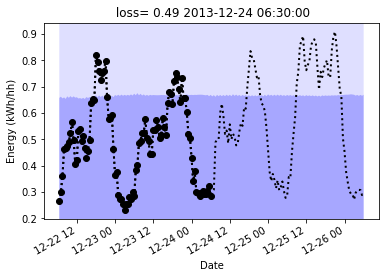

step val 0, {'val_loss': '0.43972402811050415', 'val/kl': '0.0007097976631484926', 'val/std': '0.6919826865196228', 'val/mse': '0.30210795998573303'} {}


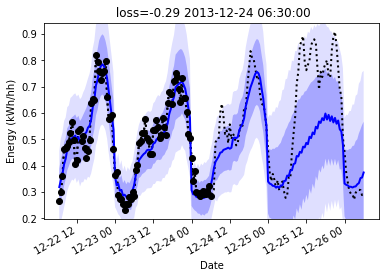

step val 1826, {'val_loss': '-0.5858442187309265', 'val/kl': '0.0006598228355869651', 'val/std': '0.09410605579614639', 'val/mse': '0.006958892568945885'} {'train_loss': -0.33417654037475586, 'train/kl': 0.0014772284775972366, 'train/std': 0.1403888314962387, 'train/mse': 0.01704699546098709}


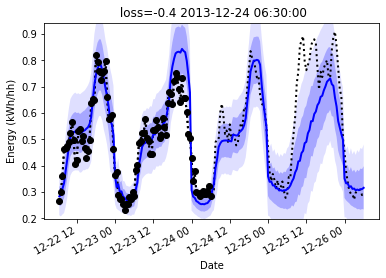

step val 3653, {'val_loss': '-0.6686775088310242', 'val/kl': '0.0009602832142263651', 'val/std': '0.07635167241096497', 'val/mse': '0.005667319055646658'} {'train_loss': -0.5634565353393555, 'train/kl': 0.00099954626057297, 'train/std': 0.08863253146409988, 'train/mse': 0.008533040061593056}


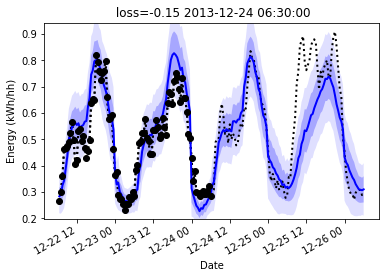

step val 5480, {'val_loss': '-0.6738855838775635', 'val/kl': '0.0011280584149062634', 'val/std': '0.06758157163858414', 'val/mse': '0.005165729206055403'} {'train_loss': -0.6472221612930298, 'train/kl': 0.000892972166184336, 'train/std': 0.07482174038887024, 'train/mse': 0.0071046543307602406}


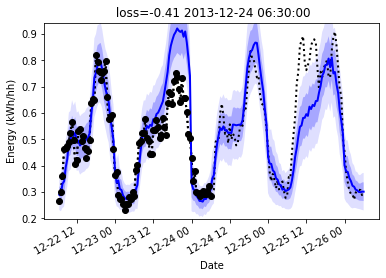

step val 7307, {'val_loss': '-0.70184725522995', 'val/kl': '0.0010905503295361996', 'val/std': '0.06405500322580338', 'val/mse': '0.0052343374118208885'} {'train_loss': -0.6811671853065491, 'train/kl': 0.0009102242183871567, 'train/std': 0.0716802105307579, 'train/mse': 0.006746941711753607}


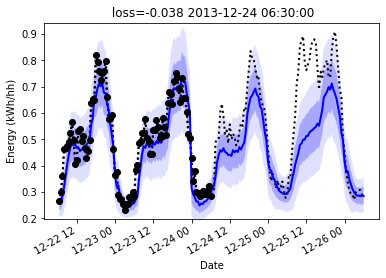

step val 9134, {'val_loss': '-0.5500525236129761', 'val/kl': '0.0009421015274710953', 'val/std': '0.06198791787028313', 'val/mse': '0.007641741540282965'} {'train_loss': -0.6953110098838806, 'train/kl': 0.0009224566165357828, 'train/std': 0.06881076097488403, 'train/mse': 0.0062933326698839664}


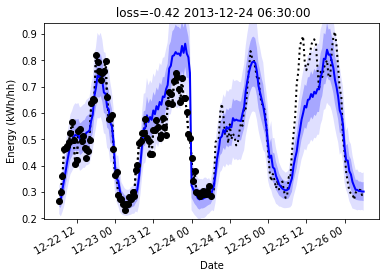

step val 10961, {'val_loss': '-0.6818557381629944', 'val/kl': '0.0011996693210676312', 'val/std': '0.06289203464984894', 'val/mse': '0.005356952082365751'} {'train_loss': -0.714325487613678, 'train/kl': 0.0008994181989692152, 'train/std': 0.06746730208396912, 'train/mse': 0.0061125620268285275}


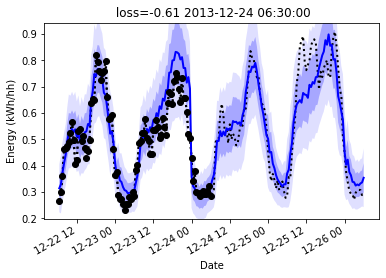

step val 12788, {'val_loss': '-0.6514759063720703', 'val/kl': '0.001041244249790907', 'val/std': '0.06694939732551575', 'val/mse': '0.005263098515570164'} {'train_loss': -0.7261911630630493, 'train/kl': 0.0009054846595972776, 'train/std': 0.06656865775585175, 'train/mse': 0.005964844953268766}
Epoch     6: reducing learning rate of group 0 to 3.0000e-05.


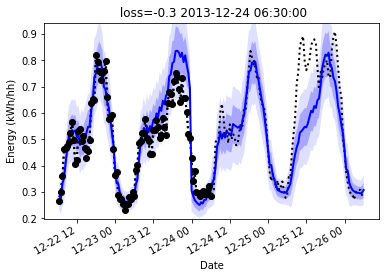

step val 14615, {'val_loss': '-0.6710492372512817', 'val/kl': '0.0007999538211151958', 'val/std': '0.05366721376776695', 'val/mse': '0.004832404665648937'} {'train_loss': -0.7789111137390137, 'train/kl': 0.0008972201612778008, 'train/std': 0.059919100254774094, 'train/mse': 0.005034992005676031}
INFO:root:Epoch 00008: early stopping

Loading checkpoint lightning_logs/anp_c/version_-3/_ckpt_epoch_3.ckpt


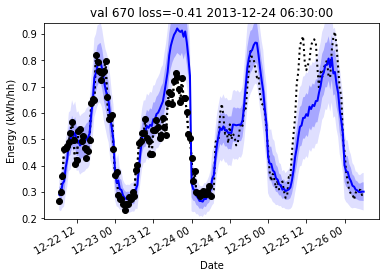

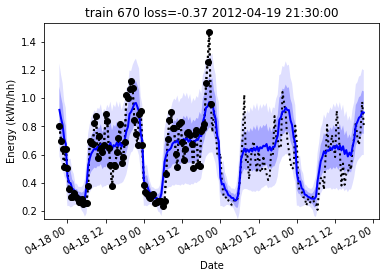

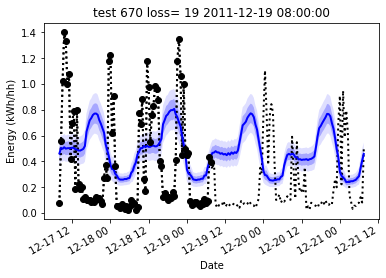

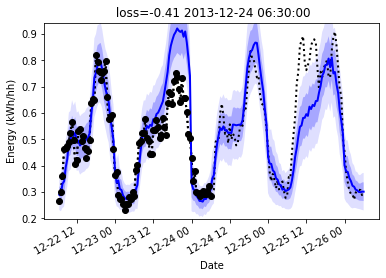

step val 14616, {'val_loss': '10.456031799316406', 'val/kl': '0.0010208823950961232', 'val/std': '0.06455948948860168', 'val/mse': '0.13285928964614868'} {}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



In [15]:
trial, trainer, model = run_trial(name="anp_c",
                                  params={
                                      **default_params,
                                      'det_enc_cross_attn_type': 'multihead',
                                      'det_enc_self_attn_type': 'uniform',
                                      'latent_enc_self_attn_type': 'uniform',
                                      'use_deterministic_path': False,
                                      'use_lvar': False,
                                  },
                                  user_attrs=default_attrs,
                                  PL_MODEL_CLS=LatentModelPL)

# NP

now run `tensorboard --logdir lightning_logs`
trial.number -3
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
   | Name                                                                      | Type                 | Params
---------------------------------------------------------------------------------------------------------------
0  | model                                                                     | LatentModel          | 1 M   
1  | model.norm_x                                                              | BatchNormSequence    | 34    
2  | model.norm_x.norm                                                         | BatchNorm1d          | 34    
3  | model.norm_y                                                              | BatchNormSequence    | 2     
4  | model.norm_y.norm                                                         | BatchNorm1d          | 2     
5  | model._latent_encoder                                                     | 

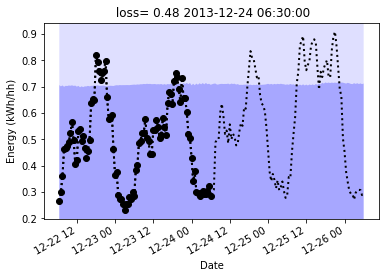

step val 0, {'val_loss': '0.43965253233909607', 'val/kl': '0.0007104985415935516', 'val/std': '0.7188370823860168', 'val/mse': '0.28676602244377136'} {}


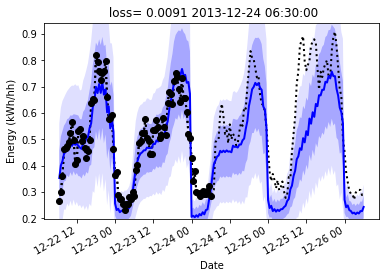

step val 1826, {'val_loss': '-0.34990647435188293', 'val/kl': '0.00030192238045856357', 'val/std': '0.11379449814558029', 'val/mse': '0.006947554647922516'} {'train_loss': -0.439557820558548, 'train/kl': 0.0012542756740003824, 'train/std': 0.11547033488750458, 'train/mse': 0.013290957547724247}


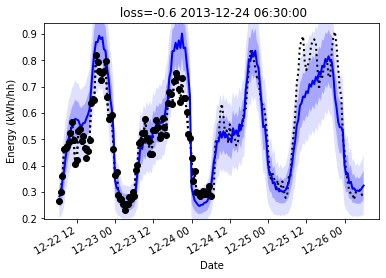

step val 3653, {'val_loss': '-0.6986027956008911', 'val/kl': '0.0006248955614864826', 'val/std': '0.06708841770887375', 'val/mse': '0.003856524359434843'} {'train_loss': -0.6183815002441406, 'train/kl': 0.000953543814830482, 'train/std': 0.07871614396572113, 'train/mse': 0.007680246606469154}


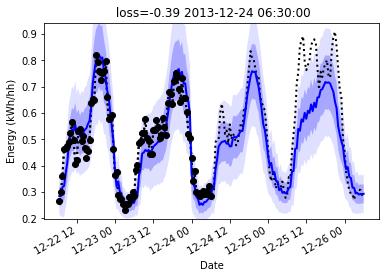

step val 5480, {'val_loss': '-0.6144722700119019', 'val/kl': '0.0006286696880124509', 'val/std': '0.08452112972736359', 'val/mse': '0.005910444539040327'} {'train_loss': -0.6634783148765564, 'train/kl': 0.0009074566187337041, 'train/std': 0.07310361415147781, 'train/mse': 0.006944151595234871}


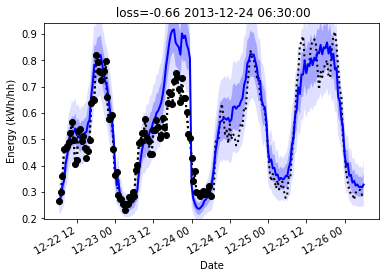

step val 7307, {'val_loss': '-0.6824144721031189', 'val/kl': '0.0009006955660879612', 'val/std': '0.056882087141275406', 'val/mse': '0.004766825120896101'} {'train_loss': -0.6888368725776672, 'train/kl': 0.0008937152451835573, 'train/std': 0.06954135000705719, 'train/mse': 0.006349148694425821}


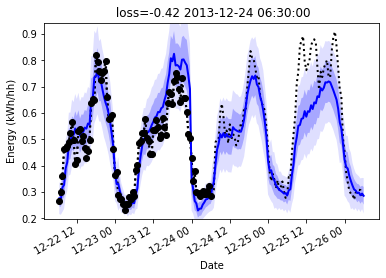

step val 9134, {'val_loss': '-0.6076558828353882', 'val/kl': '0.0007585150306113064', 'val/std': '0.06220545992255211', 'val/mse': '0.006551452446728945'} {'train_loss': -0.712720513343811, 'train/kl': 0.0008679977036081254, 'train/std': 0.06662549078464508, 'train/mse': 0.005996646825224161}
Epoch     4: reducing learning rate of group 0 to 3.0000e-05.


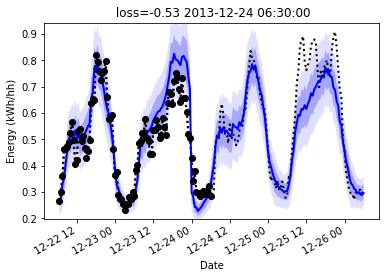

step val 10961, {'val_loss': '-0.5856883525848389', 'val/kl': '0.0006908770883455873', 'val/std': '0.054788023233413696', 'val/mse': '0.005983424372971058'} {'train_loss': -0.7709274888038635, 'train/kl': 0.0008735057199373841, 'train/std': 0.06009318307042122, 'train/mse': 0.005061835516244173}
INFO:root:Epoch 00006: early stopping

Loading checkpoint lightning_logs/np/version_-3/_ckpt_epoch_1.ckpt


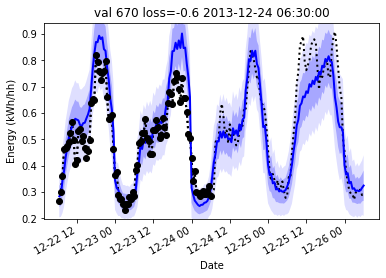

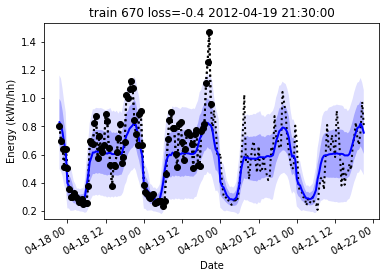

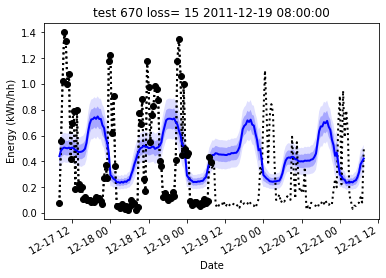

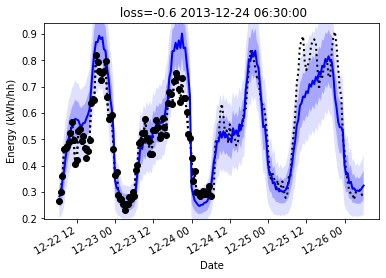

step val 10962, {'val_loss': '11.563106536865234', 'val/kl': '0.0010463492944836617', 'val/std': '0.057270597666502', 'val/mse': '0.1271519660949707'} {}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



In [16]:
trial, trainer, model = run_trial(name="np",
                                  params={
                                      **default_params,
                                      'det_enc_cross_attn_type': 'uniform',
                                      'det_enc_self_attn_type': 'uniform',
                                      'latent_enc_self_attn_type': 'uniform',
                                      'use_deterministic_path': False,
                                      'use_lvar': False,
                                  },
                                  user_attrs=default_attrs,
                                  PL_MODEL_CLS=LatentModelPL)

In [17]:
# trial, trainer, model = run_trial(name="np",
#                                   params={
#                                       **default_params,
#                                       'det_enc_cross_attn_type': 'uniform',
#                                       'det_enc_self_attn_type': 'uniform',
#                                       'latent_enc_self_attn_type': 'uniform',
#                                       'use_deterministic_path': False,
#                                   },
#                                   user_attrs=default_attrs,
#                                   PL_MODEL_CLS=LatentModelPL)

# Hyperparam

In [18]:
import argparse 

parser = argparse.ArgumentParser(description='PyTorch Lightning example.')
parser.add_argument('--pruning', '-p', action='store_true',
                    help='Activate the pruning feature. `MedianPruner` stops unpromising '
                         'trials at the early stages of training.')
args = parser.parse_args(['-p'])

pruner = optuna.pruners.MedianPruner(n_warmup_steps=1, n_startup_trials=20) if args.pruning else optuna.pruners.NopPruner()
pruner = optuna.pruners.PercentilePruner(75.0)
name = 'anp-rnn1'
study = optuna.create_study(direction='minimize', pruner=pruner, storage=f'sqlite:///optuna_result/{name}.db', study_name=name, load_if_exists=True)


[I 2020-03-16 01:24:47,330] Using an existing study with name 'anp-rnn1' instead of creating a new one.


In [19]:
study.optimize(objective, n_trials=200, timeout=pd.Timedelta('3d').total_seconds())

[W 2020-03-16 01:24:47,560] Setting status of trial#1 as TrialState.FAIL because of the following error: TypeError("objective() missing 1 required positional argument: 'PL_MODEL_CLS'")
Traceback (most recent call last):
  File "/home/wassname/.pyenv/versions/jup3.7.3/lib/python3.7/site-packages/optuna/study.py", line 569, in _run_trial
    result = func(trial)
TypeError: objective() missing 1 required positional argument: 'PL_MODEL_CLS'


TypeError: objective() missing 1 required positional argument: 'PL_MODEL_CLS'

In [ ]:

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

# shutil.rmtree(MODEL_DIR)

## View

TODO

In [ ]:
df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
df.sort_values('value')

In [ ]:
df.sort_values('value').head(17).T